For this demonstration we will be simulating a SrTiO3 CeO2 interface downloaded from https://www.materialscloud.org/explore/stoceriaitf/grid/calculations. We first import the multislice library, read in and plot the crystal and set up some basic parameters for our simulation.

<IPython.core.display.Javascript object>


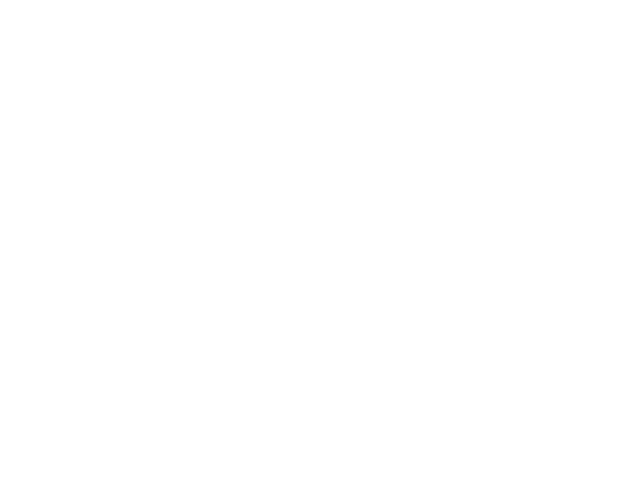

In [1]:
import pyms
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
#Get crystal
crystal = pyms.crystal('Structures/SrTiO3_CeO2_interface.xyz')

#A few maniupulations to remove vaccuum at edges and create a psuedo-periodic
#structure
crystal = crystal.slice([0.1,0.76],axis=0)
crystal = crystal.concatenate_crystals(crystal.slice([0.017,0.99],
                                    axis=0).reflect([0]),axis=0)
#Output structure for examination in Vesta 
crystal.output_vesta_xtl('manipulated.xtl')

#Quick plot of crystal
crystal.quickplot(atomscale=1e-5)

#Subslicing of crystal for multislice
subslices = [0.33,0.66,1.0]
nsubslices = len(subslices)

#Grid size in pixels
gridshape = [1024,1024]
tiling = [1,7]

#Size of real space grid
rsize = np.zeros((3,))
rsize[:3]  = crystal.unitcell[:3]
rsize[:2] *= np.asarray(tiling)

#Number of transmission functions
nT = 4

#Probe accelerating voltage in eV
eV = 3e5

#Objective aperture in mrad
app = 15

#Number of frozen phonon passes
nfph = 25

Set up and look at transmission functions

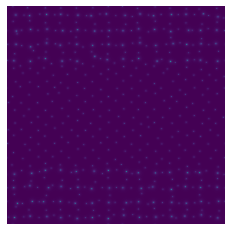

interactive(children=(IntSlider(value=0, description='Slice:', max=13), Output()), _dom_classes=('widget-inter…

<function __main__.plot_img(i, img, p)>

In [2]:
import torch
from pyms.utils import cx_to_numpy

# Transmission functions wouldn't fit on the GPU of my test computer, uncomment the following
# to utilize GPU acceleration
#Choose GPU if available and CPU if not
#if (torch.cuda.is_available()):
#    device = torch.device('cuda:0')
#else:
device = torch.device('cpu')

#Subslice every 2 Angstrom
nsubslices = int(np.ceil(crystal.unitcell[2]/2))
subslices = np.linspace(1.0/nsubslices,1.0,num = nsubslices)

#Initialize array to store transmission functions in
T = torch.zeros(nT,nsubslices,*gridshape,2,device=device)

#Make transmission functions
for i in range(nT):
    T[i,:,:,:] = crystal.make_transmission_functions(gridshape,eV,subslices,tiling,fftout=True,device=device)


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#Now plot transmission function with slider widget to inspect individual slices

fig,ax = plt.subplots(figsize=(4,4))
p = ax.imshow(np.angle(cx_to_numpy(T[0,0,...])),vmax=0.6*np.amax(np.angle(T[0,0,...])),vmin=np.amin(np.angle(T[0,0,...])))
ax.set_axis_off()

def plot_img(i,img,p):
    p.set_data(np.angle(cx_to_numpy(img[0,i,...])))
    fig.canvas.draw_idle()
#     p.set_title()

widg = widgets.IntSlider(
    value=0,
    min=0,
    max=T.shape[1]-1,
    step=1,
    description='Slice:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
interact(plot_img,i=widg,img=fixed(T), p=fixed(p))

Now calculate TEM images for a range of defocii

In [3]:
from tqdm import tqdm


# Make Fresnel free-space propagators for multislice algorithm
propagators = pyms.make_propagators(gridshape,rsize,eV,subslices)

# Set up thickness series
tstep = 100
thicknesses = np.asarray([200])
nt = thicknesses.shape[0]

nfph = 10



#Make lens contrast transfer functions for a defocus series
defocii = np.arange(-2e3,2e3+1,1e2)
ndf = defocii.shape[0]
CTFs = np.zeros((ndf,*gridshape),dtype=np.complex)
for idf,df in enumerate(defocii):
    CTFs[idf,...] = pyms.make_contrast_transfer_function(gridshape,rsize,eV,app,df=df)

#initialize array to store output
output = np.zeros((ndf,*gridshape))    
    
#Iteration over frozen phonon configurations
for ifph in tqdm(range(nfph)):
    # Make probe
    probe = pyms.plane_wave_illumination(gridshape,rsize)
    
    # Run multislice
    for it,t in enumerate(thicknesses):
        probe = pyms.multislice(probe,propagators,T,
                                int(np.ceil(tstep/crystal.unitcell[2])),tiling=tiling
                                ,device_type=device)
        for idf in range(ndf):
            output[idf,...] = np.abs(np.fft.ifft2(np.fft.fft2(probe)*CTFs[idf,...]))**2

output/= nfph

    

100%|██████████| 10/10 [01:48<00:00, 11.25s/it]


Plot resulting images

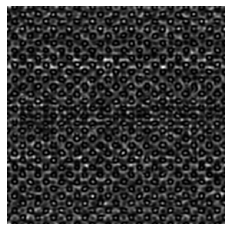

interactive(children=(IntSlider(value=0, description='Test:', max=40), Output()), _dom_classes=('widget-intera…

<function __main__.plot_img(i, img, p)>

In [4]:
fig,ax = plt.subplots(figsize=(4,4))
p = ax.imshow(output[0,...],vmax=0.6*np.amax(output),vmin=np.amin(output),
             cmap=plt.get_cmap('gray'))
ax.set_axis_off()

def plot_img(i,img,p):
    p.set_data(img[i,...])
    fig.canvas.draw_idle()
#     p.set_title()

widg = widgets.IntSlider(
    value=0,
    min=0,
    max=output.shape[0]-1,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
interact(plot_img,i=widg,img=fixed(output), p=fixed(p))

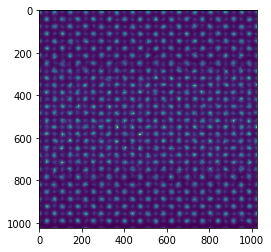

In [5]:
fig,ax= plt.subplots()
ax.imshow(np.sum(np.angle(cx_to_numpy(T)),axis=(0,1)))


Set up precession

In [ ]:
precession_angle = 15
nazimuths = 32
azimuths = np.linspace(0,2*np.pi,num=nazimuths,endpoint=False)
tilts = precession_angle*np.asarray([np.cos(azimuths),np.sin(azimuths)])

output = np.zeros((ndf,*gridshape))

#Iteration over frozen phonon configurations
for itilt in tqdm(range(nazimuths)):
    for ifph in range(nfph):
        # Make probe
        probe = pyms.plane_wave_illumination(gridshape,rsize[:2],tilts[:,itilt],eV=eV)

        # Run multislice
        for it,t in enumerate(thicknesses):
            probe = pyms.multislice(probe,propagators,T,
                                    int(np.ceil(tstep/crystal.unitcell[2])),tiling=tiling
                                    ,device_type=device)
            for idf in range(ndf):
                output[idf,...] += np.abs(np.fft.ifft2(np.fft.fft2(probe)*CTFs[idf,...]))**2

fig,ax = plt.subplots()
ax.plot(tilts[0,:],tilts[1,:],'ro')

 12%|█▎        | 4/32 [07:08<49:50, 106.79s/it]

In [ ]:
print(rsize)


In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
p = ax.imshow(output[0,...],vmax=0.6*np.amax(output),vmin=np.amin(output),
             cmap=plt.get_cmap('gray'))
ax.set_axis_off()

def plot_img(i,img,p):
    p.set_data(img[i,...])
    fig.canvas.draw_idle()
#     p.set_title()

widg = widgets.IntSlider(
    value=0,
    min=0,
    max=output.shape[0]-1,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
interact(plot_img,i=widg,img=fixed(output), p=fixed(p))

In [ ]:
import h5py

with h5py.File("Precession_TEM.hdf5", "w") as f:
    f.create_dataset('Defocus_series',shape = output.shape,data=output,dtype=output.dtype)